<a href="https://colab.research.google.com/github/rafaelmgr12/ds-projects/blob/main/CIFAR-10/Cifar_10_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.applications import EfficientNetB7


from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,MaxPooling2D ,Dropout,Conv2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

sns.set(style='white', context='notebook', palette='deep')

In [2]:
# The data, split between train and test sets:
(x, y), (x_test, y_test) = datasets.cifar10.load_data()
print('x_train shape:', x.shape)
print('y_train shape:', y.shape)
print(x.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


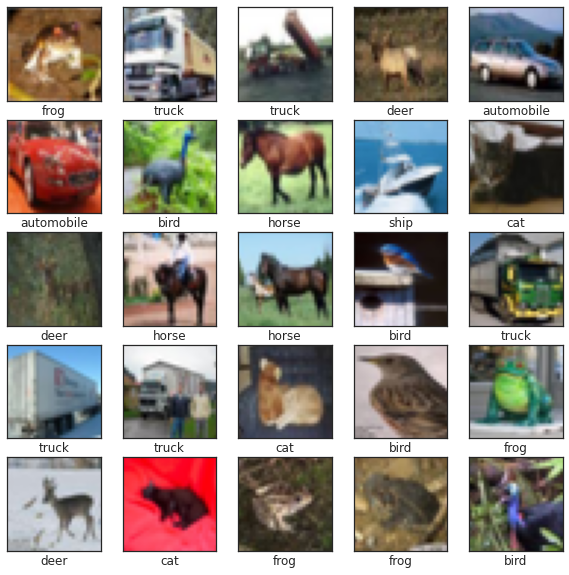

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y[i][0]])
plt.show()

In [4]:
# Normalize the data. Before we need to connvert data type to float for computation.
x = x.astype('float32')
x_test = x_test.astype('float32')
x /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y = tf.keras.utils.to_categorical(y, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
x_train, X_val, y_train, Y_val = train_test_split(x, y, test_size = 0.2)

In [6]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        )

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [7]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
EarlyStop = EarlyStopping(monitor='accuracy', mode='auto', patience=25)


In [8]:
epochs = 100 
batch_size = 128


In [9]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

## Pre-Trained Models

In [10]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz
!tar -xf noisy_student_efficientnet-b7.tar.gz

--2021-08-17 12:44:53--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491946092 (469M) [application/octet-stream]
Saving to: ‘noisy_student_efficientnet-b7.tar.gz.1’

noisy_student_effic 100%[===================>] 469.16M   225MB/s    in 2.1s    

2021-08-17 12:44:55 (225 MB/s) - ‘noisy_student_efficientnet-b7.tar.gz.1’ saved [491946092/491946092]



In [11]:
!python efficientnet_weight_update_util.py --model b7 --notop --ckpt /content/noisy_student_efficientnet-b7/model.ckpt --o efficientnetb7_notop.h5

2021-08-17 12:45:02.257912: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 12:45:03.638813: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 12:45:03.692539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 12:45:03.693125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-08-17 12:45:03.693170: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 12:45:03.811953: I tensorflow/stream_executor/pl

In [12]:
base_model = EfficientNetB7(input_shape = (32, 32, 3), include_top = False, weights = '/content/efficientnetb7_notop.h5')


In [13]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)
# Add a dropout rate of 0.5
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.125)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.06275)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(10,activation= 'softmax')(x)
model = tf.keras.models.Model(base_model.input, x)

In [14]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
eff_history = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    epochs = epochs,validation_data = (X_val,Y_val),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction,EarlyStop])

Epoch 1/100
312/312 [==============================] - 157s 318ms/step - loss: 2.0535 - accuracy: 0.2164 - val_loss: 4.2701 - val_accuracy: 0.1063
Epoch 2/100
312/312 [==============================] - 94s 302ms/step - loss: 1.5807 - accuracy: 0.4072 - val_loss: 32.4144 - val_accuracy: 0.1095
Epoch 3/100
312/312 [==============================] - 95s 303ms/step - loss: 1.2259 - accuracy: 0.5746 - val_loss: 4.4592 - val_accuracy: 0.1441
Epoch 4/100
312/312 [==============================] - 94s 302ms/step - loss: 1.0337 - accuracy: 0.6556 - val_loss: 2.0595 - val_accuracy: 0.3203
Epoch 5/100
312/312 [==============================] - 94s 302ms/step - loss: 0.9205 - accuracy: 0.6967 - val_loss: 2.9926 - val_accuracy: 0.1059
Epoch 6/100
312/312 [==============================] - 94s 302ms/step - loss: 0.8324 - accuracy: 0.7320 - val_loss: 1.9199 - val_accuracy: 0.3406
Epoch 7/100
312/312 [==============================] - 94s 302ms/step - loss: 0.7563 - accuracy: 0.7563 - val_loss: 1.7155

In [1]:
# list all data in history
print(eff_history.history.keys())

plotmodelhistory(eff_history)

NameError: ignored

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

In [ ]:
model.save("EfficientNet-conv.h5")